In [1]:
get_ipython().magic('matplotlib inline')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

data=pd.read_excel('caschool.xlsx.xls')

state=440232650+470353886+470352982 # sum of the student IDs for the members of the group

train = data.sample(frac=0.8, random_state=state) # For tasks 1-5 
test = data[data.index.isin(train.index)==False].copy() # Only for prediction (task 6)

train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

For each of the proposed models we will want: 
1. OLS
2. VIF
3. SER
4. $R^2-adj$ 
5. Residual Plot

In [ ]:
# creating a log of a variable/predictor:
train['log_testscr or variable'] = np.log(train['testscr or variable'])

# to square-root Y:
train['testscr_sqr'] = np.sqrt(train['testscr'])

# to square Y:
train['testscr_sq2'] = train['testscr']**2

# creating knots for linear splines - this example splits at 20,40,60 and 80%:
xi1=train['testscr'].quantile(.2) 
xi2=train['testscr'].quantile(.4)
xi3=train['testscr'].quantile(.6)
xi4=train['testscr'].quantile(.8)
train['Step1']=(train['testscr']>xi1)*(train['testscr']-xi1)
train['Step2']=(train['testscr']>xi2)*(train['testscr']-xi2)
train['Step3']=(train['testscr']>xi3)*(train['testscr']-xi3)
train['Step4']=(train['testscr']>xi4)*(train['testscr']-xi4)

# creating cubic splines using knot positions defined above
train['Step31']=(train['testscr']>xi1)*(train['testscr']-xi1)**3
train['Step32']=(train['testscr']>xi2)*(train['testscr']-xi2)**3
train['Step33']=(train['testscr']>xi3)*(train['testscr']-xi3)**3
train['Step34']=(train['testscr']>xi4)*(train['testscr']-xi4)**3

In [ ]:
# 1. OLS
import statsmodels.formula.api as smf
import statsmodels.api as sm
# insert formula you want, str must always be included as a variable

# for interation effects use 'C:(variable1, variable2)'

# to create a polynomial use '+ np.power(EngDispl, 2)' where 2 is the degree you're raising the variable to 
formula='testscr ~ str + avginc + el_pct + expn_stu + comp_stu'
ols1 = smf.ols(formula=formula, data=train).fit()
resid1 = ols1.resid
fitted1 = ols1.fittedvalues
ols1.summary()

In [ ]:
# 2. VIF

features = train[['str','avginc','el_pct', 'expn_stu','comp_stu']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(6): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

In [ ]:
# average VIF
np.mean(vif)

In [ ]:
# 3. and 4.  SER, Rsq and Rsq adj

# For a linear Y:
ols1.mse_resid**0.5 # SER

    # Rsq and Rsq Adj are in the OLS summary

# For logY:
    # can do this without bias correction (BC), Duan BC (non-normal errors), or Normal BC (normal errors)
    # this example assumes a loglin model, its the same with a loglog model

eres1 = np.exp(resid1) # exponential of errors
n = len(resid1)
fp1 = sum(eres1)/n # Duan BC factor
fp11 = np.exp(ols1.mse_resid/2) # Normal BC factor

    # untransform Y 
testscr_loglin = np.exp(fitted1) # no BC
testscr_loglin1 = np.exp(fitted1) * fp1 # Duan
testscr_loglin11 = np.exp(fitted1) * fp11 # Normal

    # get variance for calculating SER, R2 etc, it will never change
stats.describe(train['testscr'])

    # calculate new residuals and then SER, Rsq and Rsq adj for each BC, p is the number of predictors
res_loglin = train['testscr']-testscr_loglin
np.sqrt(sum(res_loglin**2)/(n-p-1)), 1 - sum(res_loglin**2)/((n-1)*variance), 1 - sum(res_loglin**2)/(n-p-1)/variance

res_loglin1 = train['testscr']-testscr_loglin1
np.sqrt(sum(res_loglin1**2)/(n-p-1)), 1 - sum(res_loglin1**2)/((n-1)*variance), 1 - sum(res_loglin1**2)/(n-p-1)/variance

res_loglin11 = train['testscr']-testscr_loglin11
np.sqrt(sum(res_loglin11**2)/(n-p-1)), 1 - sum(res_loglin11**2)/((n-1)*variance), 1 - sum(res_loglin11**2)/(n-p-1)/variance


# For square-root Y
testscr_pred_sq2 = fitted1**2 #square the fitted values to get Y

    # find residuals then SER, R2, R2 adj, p is the number of predictors
res_pred_sq2 = train['testscr']-testscr_pred_sq2
np.sqrt(sum(res_pred_sq2**2)/(n-p-1)), 1 - sum(res_pred_sq2**2)/((n-1)*variance), 1 - sum(res_pred_sq2**2)/(n-p-1)/variance

# for Y^2 
testscr_pred_sqr = np.sqrt(fitted1) #square root the fitted values to get Y
    # find residuals then SER, R2, R2 adj
res_pred_sqr = train['testscr']-testscr_pred_sqr
np.sqrt(sum(res_pred_sqr**2)/(n-p-1)), 1 - sum(res_pred_sqr**2)/((n-1)*variance), 1 - sum(res_pred_sqr**2)/(n-p-1)/variance

In [ ]:
# 5. Residuals, gives LOESS, true line

fig, ax= plt.subplots()
sns.regplot(fitted1, resid1, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model X') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

In [ ]:
# Histogram of residuals (to check whether the distrubution is uniform/normal)

ax = sns.distplot(resid1, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risdual Histogram - Model X')
plt.show()

In [ ]:
# numerical summary of residuals
from scipy import stats
stats.describe(resid1)

In [ ]:
# gives a graph of the residuals squared with a true fit line (good for checking homoskedasticity)
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
lowess = sm.nonparametric.lowess
fig, ax= plt.subplots()
sns.regplot(fitted1,resid1**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residual squared', {'fontsize': 12})
z1 = lowess(resid**2, fitted1, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [28]:
summary = []

# Model 1 - Full Linear

In [2]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
formula1="testscr ~ str + enrl_tot + expn_stu + el_pct + meal_pct + calw_pct + avginc + comp_stu"
ols1 = smf.ols(formula=formula1, data=train).fit()
resid1 = ols1.resid
fitted1 = ols1.fittedvalues
ols1.summary()

C:\Users\sarah\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     191.5
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          1.69e-118
Time:                        21:30:34   Log-Likelihood:                -1173.4
No. Observations:                 336   AIC:                             2365.
Df Residuals:                     327   BIC:                             2399.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    653.2234      9.987     65.409      0.000     633.577     672.870
str           -0.0088      0.315     -0.028      0.978      -0.629       0.612
enrl_tot    4.651e-05      0.000      0.385      0.700      -0.000       0.000
expn_stu       0.0022      0.001      2.218      0.027       0.000       0.004
el_pct        -0.1677      0.038     -4.414      0.000      -0.242      -0.093
meal_pct      -0.4128      0.038    -10.742      0.000      -0.488      -0.337
calw_pct      -0.0464      0.061     -0.763      0.446      -0.166       0.073
avginc         0.5591      0.095      5.856      0.000       0.371       0.747
comp_stu      18.1337      7.540      2.405      0.017       3.300      32.967
==============================================================================
Omnibus:                       10.806   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               19.906
Skew:                          -0.113   Prob(JB):                     4.76e-05
Kurtosis:                       4.171   Cond. No.                     1.46e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [77]:
features = train[['str','enrl_tot','expn_stu','el_pct','meal_pct','calw_pct','avginc','comp_stu']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(8): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[1.8971783488415279, 1.2929902514200253, 2.0303339628419699, 2.4056080542115739, 5.6454842424232723, 2.5869771063290701, 2.4069689494859001, 1.2147998150442438]


In [78]:
np.mean(vif)

2.4350425913246978

In [5]:
ols1.mse_resid**0.5# SER

8.0595836938627468

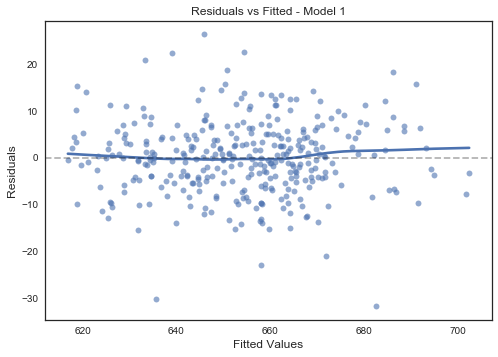

In [7]:
fig, ax= plt.subplots()
sns.regplot(fitted1, resid1, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted Values',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model 1') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

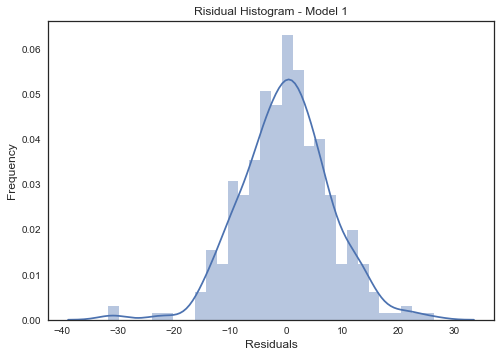

In [8]:
ax = sns.distplot(resid1, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risidual Histogram - Model 1')
plt.show()

In [9]:
from scipy import stats
stats.describe(resid1)

DescribeResult(nobs=336L, minmax=(-31.725776651231058, 26.30420025798287), mean=-1.2349909454877932e-11, variance=63.405680021222977, skewness=-0.11313664528637424, kurtosis=1.170736428338266)

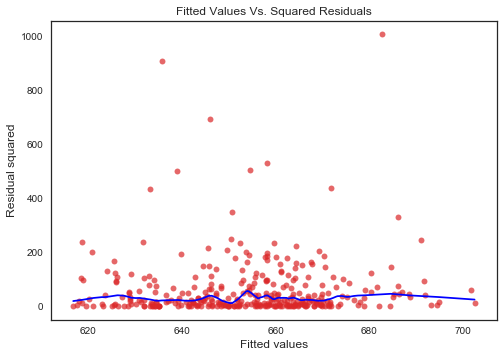

In [11]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
lowess = sm.nonparametric.lowess
sns.regplot(fitted1,resid1**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residual squared', {'fontsize': 12})
ax.set_title('Fitted Values Vs. Squared Residuals')
z1 = lowess(resid1**2, fitted1, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [29]:
summary.append({'formula': formula, 'ser': ols1.mse_resid**0.5, 'rsquared': ols1.rsquared, 'rsqured_adj': ols1.rsquared_adj})

# Model 2 - FS

In [13]:
def forward_selected(data, response, nominated = []):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    selected = nominated
    remaining.remove(response)
    remaining ^= set(selected)
    current_score, best_new_score = 0.0, 0.0
    if nominated:
        formula = "{} ~ {} + 1".format(response, ' + '.join(nominated))
        current_score= smf.ols(formula, data).fit().rsquared_adj
        best_new_score = current_score
        print("you nominated variable(s) %s, the adj_r2 is: %f" %(nominated, current_score))
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("adding %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

In [31]:
model = forward_selected(train[['testscr','str','enrl_tot','teachers','computer','expn_stu','el_pct','meal_pct','calw_pct','avginc','comp_stu']], 'testscr', nominated=['str'] )


you nominated variable(s) ['str'], the adj_r2 is: 0.049352
adding meal_pct increases adj_r2 from 0.049352 to 0.782474
adding avginc increases adj_r2 from 0.782474 to 0.802119
adding el_pct increases adj_r2 from 0.802119 to 0.814721
adding comp_stu increases adj_r2 from 0.814721 to 0.818543
adding expn_stu increases adj_r2 from 0.818543 to 0.820527
final model is testscr ~ str + meal_pct + avginc + el_pct + comp_stu + expn_stu + 1, with adj_r2 of 0.820527


In [32]:
formula2= 'testscr ~ str + meal_pct + avginc + el_pct + comp_stu + expn_stu'
ols2 = smf.ols(formula=formula2, data=train).fit()
resid2 = ols2.resid
fitted2 = ols2.fittedvalues
ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     256.3
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          9.20e-121
Time:                        21:45:04   Log-Likelihood:                -1173.7
No. Observations:                 336   AIC:                             2361.
Df Residuals:                     329   BIC:                             2388.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    653.1579      9.854     66.286      0.000     633.774     672.542
str            0.0195      0.307      0.064      0.949      -0.584       0.623
meal_pct      -0.4315      0.030    -14.497      0.000      -0.490      -0.373
avginc         0.5631      0.094      5.972      0.000       0.378       0.749
el_pct        -0.1558      0.035     -4.491      0.000      -0.224      -0.088
comp_stu      18.5204      7.415      2.498      0.013       3.934      33.107
expn_stu       0.0021      0.001      2.156      0.032       0.000       0.004
==============================================================================
Omnibus:                       11.172   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               21.013
Skew:                          -0.113   Prob(JB):                     2.74e-05
Kurtosis:                       4.204   Cond. No.                     1.21e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
features = train[['str','meal_pct','avginc','el_pct', 'comp_stu', 'expn_stu']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(6): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[1.8040816615402027, 3.4007054725955879, 2.357732977460604, 2.0126250218113295, 1.179452349139094, 1.9946350403547481]


In [35]:
np.mean(vif)

2.1248720871502607

In [36]:
ols2.mse_resid**0.5 # SER

8.0432515540219409

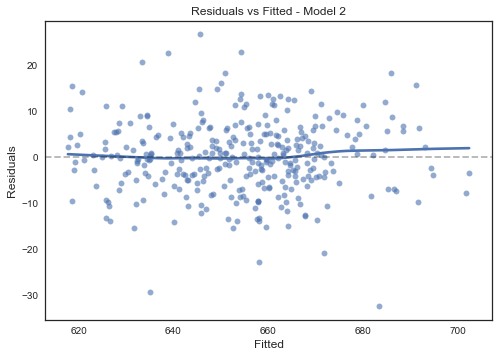

In [37]:
fig, ax= plt.subplots()
sns.regplot(fitted2, resid2, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model 2') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

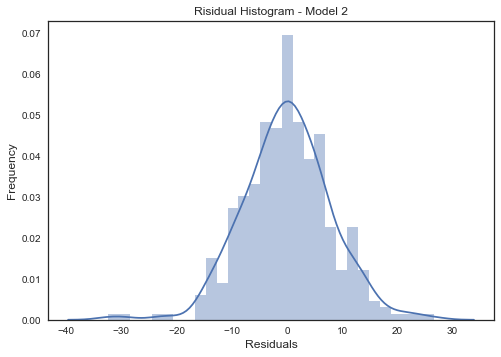

In [38]:
ax = sns.distplot(resid2, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risidual Histogram - Model 2')
plt.show()

In [39]:
from scipy import stats
stats.describe(resid2)

DescribeResult(nobs=336L, minmax=(-32.420884200171827, 26.631749610110887), mean=-8.0626299287749659e-12, variance=63.535198924357985, skewness=-0.1130613279571008, kurtosis=1.20407511985949)

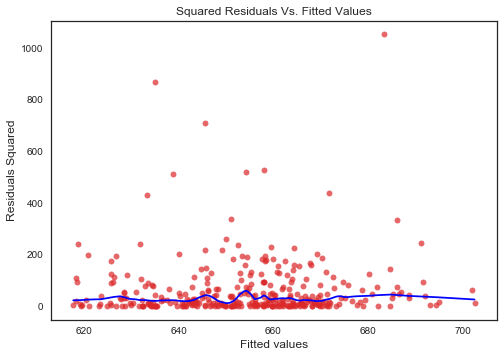

In [40]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
lowess = sm.nonparametric.lowess
sns.regplot(fitted2,resid2**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Squared Residuals Vs. Fitted Values')
z1 = lowess(resid2**2, fitted2, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [42]:
def backward_selected(data, response, nominated = []):
    """Linear model designed by backward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by backward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    if nominated:
        print("you nominated variables %s" %nominated)
    nominated = set(nominated)
    remaining^=nominated
    formula = "{} ~ {} + 1".format(response,' + '.join(remaining | nominated))
    current_score = smf.ols(formula, data).fit().rsquared_adj
    print("adj_r2 if all variables included: %f" %current_score)
    best_new_score = current_score
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(remaining^{candidate}|nominated))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("deleting %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(remaining|nominated))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

In [44]:
# backward selection gives the same model:
model = backward_selected(train[['testscr','str','enrl_tot','teachers','computer','expn_stu','el_pct','meal_pct','calw_pct','avginc','comp_stu']], 'testscr', nominated=['str'] )

you nominated variables ['str']
adj_r2 if all variables included: 0.819307
deleting enrl_tot increases adj_r2 from 0.819307 to 0.819838
deleting teachers increases adj_r2 from 0.819838 to 0.820001
deleting computer increases adj_r2 from 0.820001 to 0.820265
deleting calw_pct increases adj_r2 from 0.820265 to 0.820527
final model is testscr ~ avginc + str + meal_pct + comp_stu + expn_stu + el_pct + 1, with adj_r2 of 0.820527


In [45]:
summary.append({'formula': formula2, 'ser': ols2.mse_resid**0.5, 'rsquared': ols2.rsquared, 'rsqured_adj': ols2.rsquared_adj})

# Model 3 - FS without minor variables

In [46]:
formula3= 'testscr ~ str + meal_pct + avginc + el_pct'
ols3 = smf.ols(formula=formula3, data=train).fit()
resid3 = ols3.resid
fitted3 = ols3.fittedvalues
ols3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     369.3
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          1.25e-120
Time:                        21:50:36   Log-Likelihood:                -1180.1
No. Observations:                 336   AIC:                             2370.
Df Residuals:                     331   BIC:                             2389.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    675.9318      5.712    118.341      0.000     664.696     687.168
str           -0.5367      0.244     -2.196      0.029      -1.017      -0.056
meal_pct      -0.4183      0.030    -14.142      0.000      -0.476      -0.360
avginc         0.6491      0.090      7.181      0.000       0.471       0.827
el_pct        -0.1698      0.035     -4.856      0.000      -0.239      -0.101
==============================================================================
Omnibus:                        9.654   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               16.212
Skew:                          -0.130   Prob(JB):                     0.000302
Kurtosis:                       4.044   Cond. No.                         768.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
features = train[['str','meal_pct','avginc','el_pct']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(4): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[1.1084173320591357, 3.2518654363717454, 2.0990508134424326, 1.9805179397548611]


In [55]:
np.mean(vif)

2.1099628804070436

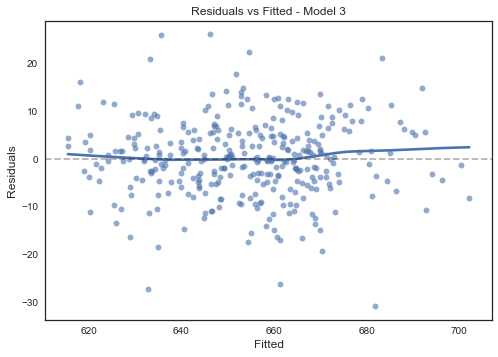

In [47]:
fig, ax= plt.subplots()
sns.regplot(fitted3, resid3, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model 3') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

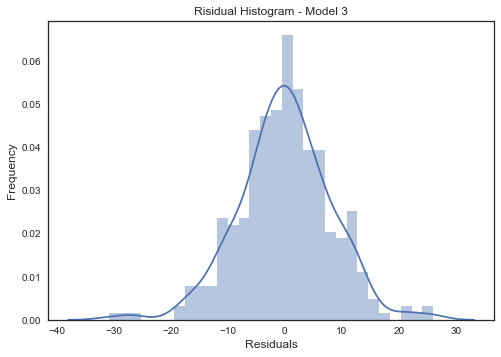

In [48]:
ax = sns.distplot(resid3, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risidual Histogram - Model 3')
plt.show()

In [49]:
from scipy import stats
stats.describe(resid3)

DescribeResult(nobs=336L, minmax=(-30.839802339965104, 25.999382955646411), mean=-7.3862609150680888e-13, variance=65.98939431029261, skewness=-0.12963446713752963, kurtosis=1.0444080458088756)

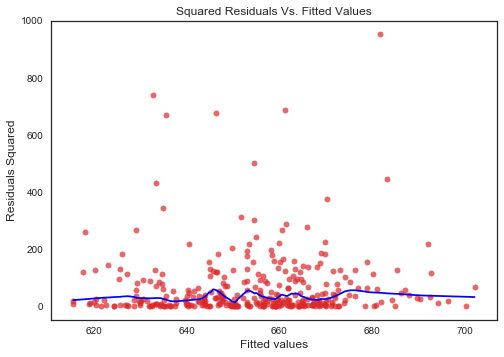

In [50]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
lowess = sm.nonparametric.lowess
sns.regplot(fitted3,resid3**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Squared Residuals Vs. Fitted Values')
z1 = lowess(resid3**2, fitted3, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [51]:
summary.append({'formula': formula3, 'ser': ols3.mse_resid**0.5, 'rsquared': ols3.rsquared, 'rsqured_adj': ols3.rsquared_adj})

# Model 4 - Model 3 Plus el_pct:str

In [58]:
train['el_str'] = train['str'] * train['el_pct']

In [59]:
formula4= 'testscr ~ str + meal_pct + avginc + el_pct + el_str'
ols4 = smf.ols(formula=formula4, data=train).fit()
resid4 = ols4.resid
fitted4 = ols4.fittedvalues
ols4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     294.9
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          2.11e-119
Time:                        22:05:00   Log-Likelihood:                -1179.9
No. Observations:                 336   AIC:                             2372.
Df Residuals:                     330   BIC:                             2395.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    678.4710      7.042     96.349      0.000     664.618     692.324
str           -0.6571      0.313     -2.100      0.036      -1.273      -0.042
meal_pct      -0.4208      0.030    -14.075      0.000      -0.480      -0.362
avginc         0.6423      0.091      7.045      0.000       0.463       0.822
el_pct        -0.3438      0.284     -1.211      0.227      -0.902       0.215
el_str         0.0088      0.014      0.618      0.537      -0.019       0.037
==============================================================================
Omnibus:                       10.168   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.108
Skew:                          -0.148   Prob(JB):                     0.000193
Kurtosis:                       4.065   Cond. No.                     7.67e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
features = train[['str','meal_pct','avginc','el_pct', 'el_str']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(5): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[1.8128362757845371, 3.3173480981562191, 2.1309431895673705, 130.36351962228431, 136.10796714445252]


In [61]:
np.mean(vif)

54.746522866048984

In [62]:
ols4.mse_resid**0.5

8.1799688774733941

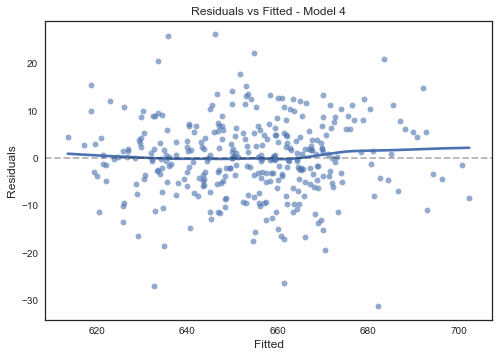

In [63]:
fig, ax= plt.subplots()
sns.regplot(fitted4, resid4, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model 4') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

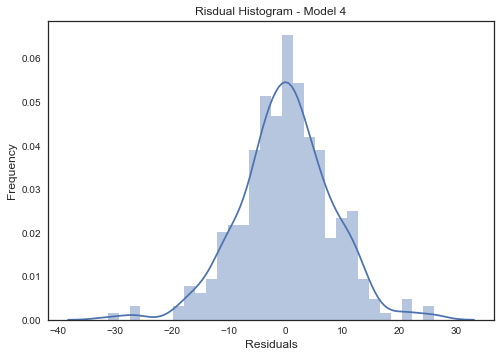

In [64]:
ax = sns.distplot(resid4, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risdual Histogram - Model 4')
plt.show()

In [65]:
from scipy import stats
stats.describe(resid4)

DescribeResult(nobs=336L, minmax=(-31.244988991976129, 26.102378199441773), mean=-3.0316490059097606e-13, variance=65.913205898576138, skewness=-0.14770426507899267, kurtosis=1.065224452488982)

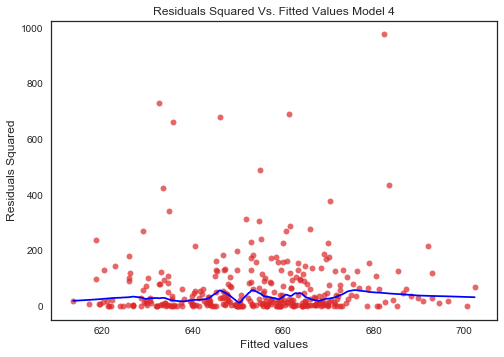

In [67]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
sns.regplot(fitted4,resid4**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Residuals Squared Vs. Fitted Values Model 4')
z1 = lowess(resid4**2, fitted4, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [68]:
summary.append({'formula': formula4, 'ser': ols4.mse_resid**0.5, 'rsquared': ols4.rsquared, 'rsqured_adj': ols4.rsquared_adj})

# Model 5 - Model 3 with calw_pct:expn_stu

In [69]:
train['calw_str'] = train['str'] * train['calw_pct']

In [72]:
formula5= 'testscr ~ str + meal_pct + avginc + el_pct + calw_pct + calw_str'
ols5 = smf.ols(formula=formula5, data=train).fit()
resid5 = ols5.resid
fitted5 = ols5.fittedvalues
ols5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     245.2
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          3.50e-118
Time:                        22:13:19   Log-Likelihood:                -1179.8
No. Observations:                 336   AIC:                             2374.
Df Residuals:                     329   BIC:                             2400.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    676.6654      8.320     81.333      0.000     660.299     693.032
str           -0.5806      0.381     -1.523      0.129      -1.331       0.169
meal_pct      -0.3996      0.039    -10.303      0.000      -0.476      -0.323
avginc         0.6510      0.092      7.044      0.000       0.469       0.833
el_pct        -0.1782      0.037     -4.758      0.000      -0.252      -0.105
calw_pct      -0.0884      0.434     -0.204      0.839      -0.942       0.765
calw_str       0.0022      0.022      0.102      0.919      -0.040       0.045
==============================================================================
Omnibus:                        9.398   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               15.207
Skew:                          -0.142   Prob(JB):                     0.000499
Kurtosis:                       4.003   Cond. No.                     6.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
features = train[['str','meal_pct','avginc','el_pct', 'calw_pct','calw_str']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(6): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[2.6855871110549683, 5.5689478288464151, 2.1841874691795868, 2.2638441385852239, 127.07802272340314, 123.96825754599401]


In [75]:
np.mean(vif)

43.958141136177225

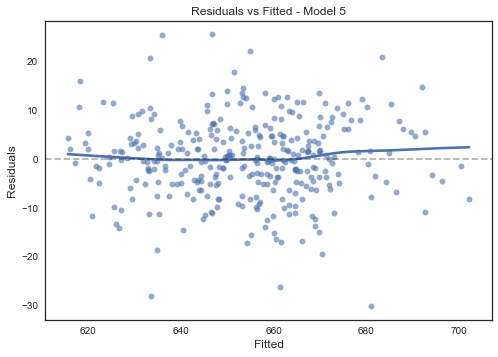

In [79]:
fig, ax= plt.subplots()
sns.regplot(fitted5, resid5, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model 5') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

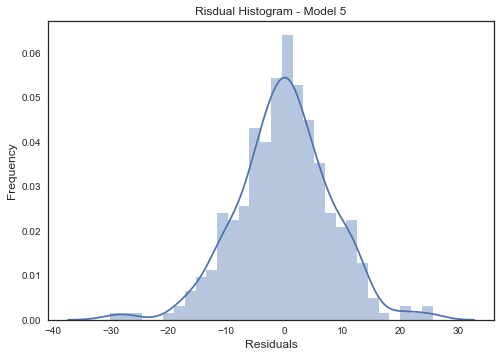

In [80]:
ax = sns.distplot(resid5, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risdual Histogram - Model 5')
plt.show()

In [81]:
from scipy import stats
stats.describe(resid5)

DescribeResult(nobs=336L, minmax=(-30.185763990533587, 25.575508628244279), mean=2.8015685009969666e-13, variance=65.878463220587435, skewness=-0.14242326229125785, kurtosis=1.0025306448756508)

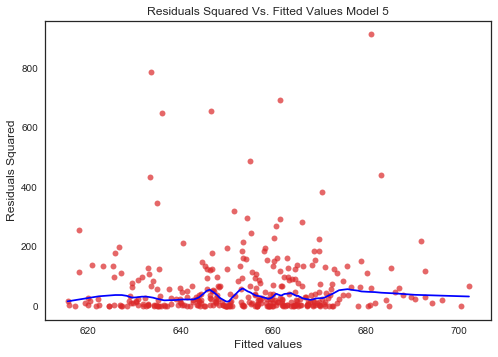

In [82]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
sns.regplot(fitted5,resid5**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Residuals Squared Vs. Fitted Values Model 5')
z1 = lowess(resid5**2, fitted5, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [83]:
summary.append({'formula': formula5, 'ser': ols5.mse_resid**0.5, 'rsquared': ols5.rsquared, 'rsqured_adj': ols5.rsquared_adj})

# Model 6 - Model 3 plus comp_stu:meal_pct

In [84]:
train['comp_meal'] = train['comp_stu'] * train['meal_pct']

In [86]:
formula6= 'testscr ~ str + meal_pct + avginc + el_pct + comp_stu + comp_meal'
ols6 = smf.ols(formula=formula6, data=train).fit()
resid6 = ols6.resid
fitted6 = ols6.fittedvalues
ols6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.0
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          8.95e-120
Time:                        22:26:56   Log-Likelihood:                -1176.1
No. Observations:                 336   AIC:                             2366.
Df Residuals:                     329   BIC:                             2393.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    670.2534      6.123    109.461      0.000     658.208     682.299
str           -0.3712      0.249     -1.489      0.137      -0.861       0.119
meal_pct      -0.4255      0.044     -9.759      0.000      -0.511      -0.340
avginc         0.6346      0.094      6.772      0.000       0.450       0.819
el_pct        -0.1568      0.035     -4.470      0.000      -0.226      -0.088
comp_stu      18.1076     13.994      1.294      0.197      -9.422      45.637
comp_meal      0.0609      0.266      0.229      0.819      -0.462       0.584
==============================================================================
Omnibus:                       10.146   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.806
Skew:                          -0.120   Prob(JB):                     0.000136
Kurtosis:                       4.102   Cond. No.                     1.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

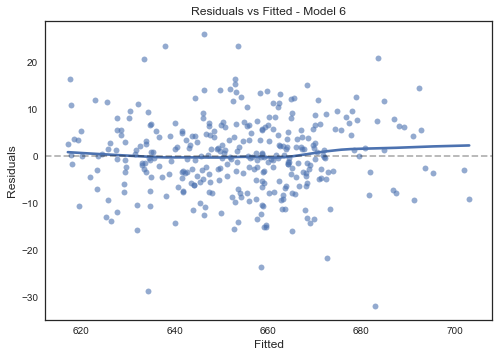

In [87]:
fig, ax= plt.subplots()
sns.regplot(fitted6, resid6, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model 6') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

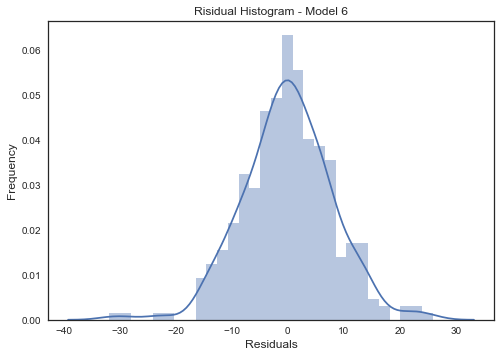

In [88]:
ax = sns.distplot(resid6, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risidual Histogram - Model 6')
plt.show()

In [90]:
from scipy import stats
stats.describe(resid6)

DescribeResult(nobs=336L, minmax=(-31.883974434612242, 25.858753040001261), mean=-2.6831447117036162e-13, variance=64.422650036942144, skewness=-0.12026715795973492, kurtosis=1.10182493082878)

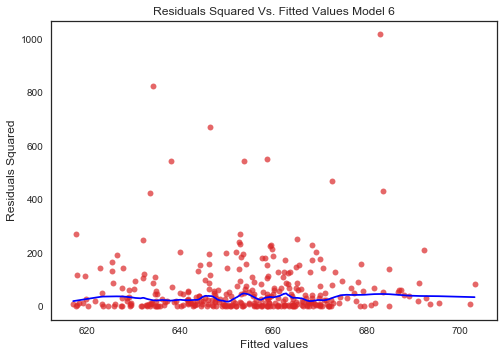

In [92]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
sns.regplot(fitted6,resid6**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Residuals Squared Vs. Fitted Values Model 6')
z1 = lowess(resid6**2, fitted6, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [93]:
summary.append({'formula': formula6, 'ser': ols6.mse_resid**0.5, 'rsquared': ols6.rsquared, 'rsqured_adj': ols6.rsquared_adj})

# Model 7 - Model 3 with meal_pct:avginc

In [94]:
train['avginc_meal'] = train['avginc'] * train['meal_pct']

In [96]:
formula7= 'testscr ~ str + meal_pct + avginc + el_pct + comp_stu + avginc_meal'
ols7 = smf.ols(formula=formula7, data=train).fit()
resid7 = ols7.resid
fitted7 = ols7.fittedvalues
ols7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     253.1
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          4.93e-120
Time:                        22:33:03   Log-Likelihood:                -1175.5
No. Observations:                 336   AIC:                             2365.
Df Residuals:                     329   BIC:                             2392.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     669.8195      6.028    111.111      0.000     657.960     681.679
str            -0.3610      0.249     -1.450      0.148      -0.851       0.129
meal_pct       -0.3851      0.042     -9.267      0.000      -0.467      -0.303
avginc          0.6597      0.094      7.023      0.000       0.475       0.844
el_pct         -0.1579      0.035     -4.531      0.000      -0.226      -0.089
comp_stu       19.8535      7.426      2.673      0.008       5.245      34.462
avginc_meal    -0.0033      0.003     -1.118      0.264      -0.009       0.003
==============================================================================
Omnibus:                       11.094   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               19.543
Skew:                          -0.153   Prob(JB):                     5.70e-05
Kurtosis:                       4.141   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

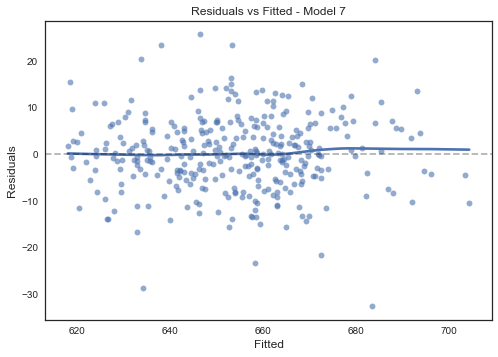

In [97]:
fig, ax= plt.subplots()
sns.regplot(fitted7, resid7, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model 7') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

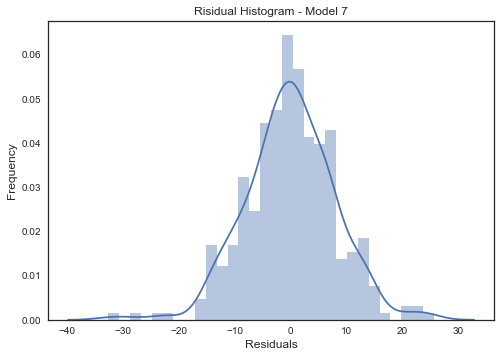

In [99]:
ax = sns.distplot(resid7, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risidual Histogram - Model 7')
plt.show()

In [100]:
from scipy import stats
stats.describe(resid7)

DescribeResult(nobs=336L, minmax=(-32.597720235735778, 25.659566673040786), mean=1.2574914654535297e-11, variance=64.188892758139801, skewness=-0.1532296521287417, kurtosis=1.1410715133985878)

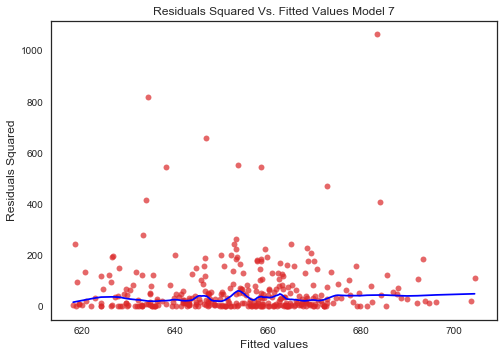

In [101]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
sns.regplot(fitted7,resid7**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Residuals Squared Vs. Fitted Values Model 7')
z1 = lowess(resid7**2, fitted7, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [102]:
summary.append({'formula': formula7, 'ser': ols7.mse_resid**0.5, 'rsquared': ols7.rsquared, 'rsqured_adj': ols7.rsquared_adj})

# Model 8 - Model 3 with expn_stu:comp_stu

In [103]:
train['expn_comp'] = train['expn_stu'] * train['comp_stu']

In [104]:
formula8= 'testscr ~ str + meal_pct + avginc + el_pct + comp_stu + expn_stu + expn_comp'
ols8 = smf.ols(formula=formula8, data=train).fit()
resid8 = ols8.resid
fitted8 = ols8.fittedvalues
ols8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     219.0
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          1.54e-119
Time:                        22:36:11   Log-Likelihood:                -1173.7
No. Observations:                 336   AIC:                             2363.
Df Residuals:                     328   BIC:                             2394.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    652.9526     14.324     45.586      0.000     624.775     681.130
str            0.0206      0.312      0.066      0.947      -0.594       0.635
meal_pct      -0.4315      0.030    -14.457      0.000      -0.490      -0.373
avginc         0.5633      0.095      5.935      0.000       0.377       0.750
el_pct        -0.1558      0.035     -4.483      0.000      -0.224      -0.087
comp_stu      19.5682     53.486      0.366      0.715     -85.650     124.786
expn_stu       0.0021      0.002      1.080      0.281      -0.002       0.006
expn_comp     -0.0002      0.010     -0.020      0.984      -0.019       0.019
==============================================================================
Omnibus:                       11.161   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               20.988
Skew:                          -0.113   Prob(JB):                     2.77e-05
Kurtosis:                       4.203   Cond. No.                     6.71e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

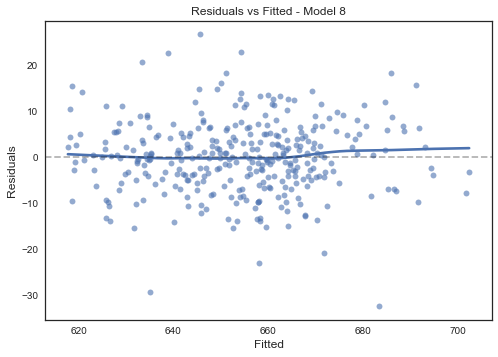

In [105]:
fig, ax= plt.subplots()
sns.regplot(fitted8, resid8, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model 8') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

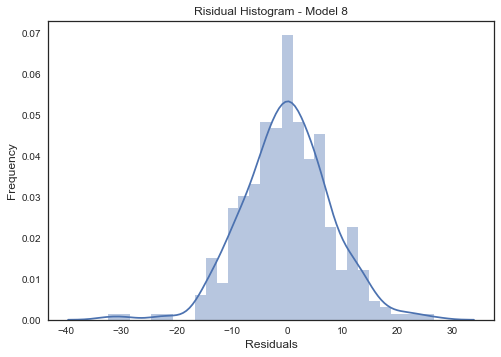

In [106]:
ax = sns.distplot(resid8, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risidual Histogram - Model 8')
plt.show()

In [107]:
from scipy import stats
stats.describe(resid8)

DescribeResult(nobs=336L, minmax=(-32.413179069002013, 26.63275493797903), mean=6.5099248742972989e-13, variance=63.535123118521192, skewness=-0.11278104995902583, kurtosis=1.2034441017882687)

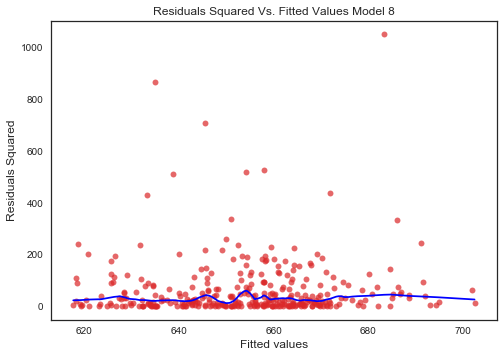

In [108]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
sns.regplot(fitted8,resid8**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Residuals Squared Vs. Fitted Values Model 8')
z1 = lowess(resid8**2, fitted8, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [109]:
summary.append({'formula': formula8, 'ser': ols8.mse_resid**0.5, 'rsquared': ols8.rsquared, 'rsqured_adj': ols8.rsquared_adj})

# Model 9 - Model 3 with avginc:comp_stu

In [110]:
train['avginc_comp'] = train['avginc'] * train['comp_stu']

In [111]:
formula9= 'testscr ~ str + meal_pct + avginc + el_pct + comp_stu + avginc_comp'
ols9 = smf.ols(formula=formula9, data=train).fit()
resid9 = ols9.resid
fitted9 = ols9.fittedvalues
ols9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.1
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          8.34e-120
Time:                        22:40:57   Log-Likelihood:                -1176.0
No. Observations:                 336   AIC:                             2366.
Df Residuals:                     329   BIC:                             2393.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     668.9329      6.516    102.663      0.000     656.115     681.751
str            -0.3772      0.249     -1.512      0.131      -0.868       0.113
meal_pct       -0.4157      0.030    -13.954      0.000      -0.474      -0.357
avginc          0.7041      0.193      3.647      0.000       0.324       1.084
el_pct         -0.1576      0.035     -4.514      0.000      -0.226      -0.089
comp_stu       26.6564     15.107      1.765      0.079      -3.062      56.374
avginc_comp    -0.3960      0.896     -0.442      0.659      -2.158       1.366
==============================================================================
Omnibus:                       10.204   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               18.080
Skew:                          -0.116   Prob(JB):                     0.000119
Kurtosis:                       4.113   Cond. No.                     2.10e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

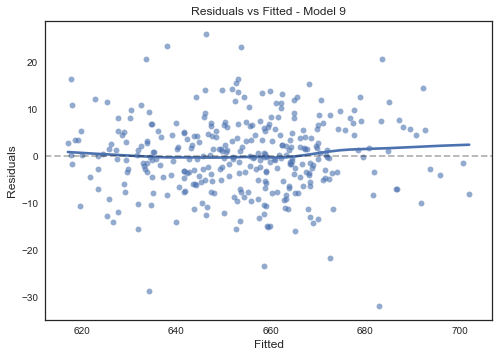

In [112]:
fig, ax= plt.subplots()
sns.regplot(fitted9, resid9, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model 9') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

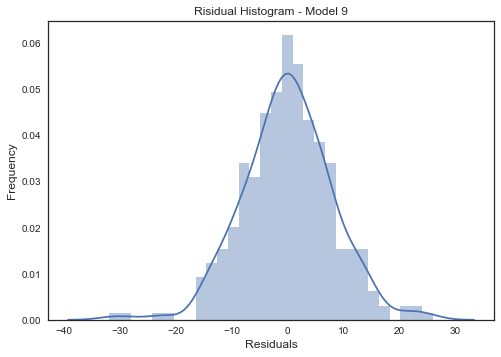

In [113]:
ax = sns.distplot(resid9, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risidual Histogram - Model 9')
plt.show()

In [114]:
from scipy import stats
stats.describe(resid9)

DescribeResult(nobs=336L, minmax=(-31.94143645080942, 25.894251068758422), mean=-1.1910049666074061e-13, variance=64.394652993062323, skewness=-0.11587730420835352, kurtosis=1.112532303250883)

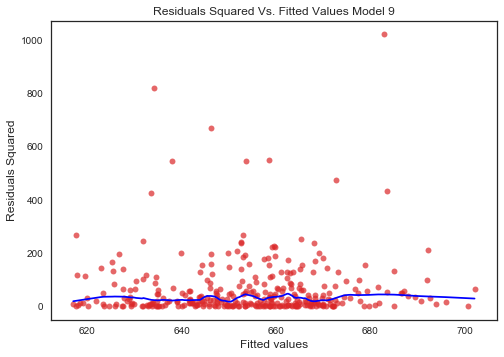

In [115]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
sns.regplot(fitted9,resid9**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Residuals Squared Vs. Fitted Values Model 9')
z1 = lowess(resid9**2, fitted9, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [116]:
summary.append({'formula': formula9, 'ser': ols9.mse_resid**0.5, 'rsquared': ols9.rsquared, 'rsqured_adj': ols9.rsquared_adj})

# Model 10 - Model 3 with Splines for meal_pct

In [117]:
xi1=train['meal_pct'].quantile(.25) 
xi2=train['meal_pct'].quantile(.5)
xi3=train['meal_pct'].quantile(.75)

train['Step1']=(train['meal_pct']>xi1)*(train['meal_pct']-xi1)
train['Step2']=(train['meal_pct']>xi2)*(train['meal_pct']-xi2)
train['Step3']=(train['meal_pct']>xi3)*(train['meal_pct']-xi3)

In [118]:
formula10= 'testscr ~ str + meal_pct + avginc + el_pct + Step1 + Step2 + Step3'
ols10 = smf.ols(formula=formula10, data=train).fit()
resid10 = ols10.resid
fitted10 = ols10.fittedvalues
ols10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     210.7
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          2.80e-117
Time:                        22:47:54   Log-Likelihood:                -1179.1
No. Observations:                 336   AIC:                             2374.
Df Residuals:                     328   BIC:                             2405.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    677.6853      6.131    110.528      0.000     665.624     689.747
str           -0.4822      0.248     -1.945      0.053      -0.970       0.005
meal_pct      -0.5315      0.119     -4.481      0.000      -0.765      -0.298
avginc         0.5978      0.103      5.815      0.000       0.396       0.800
el_pct        -0.1656      0.036     -4.557      0.000      -0.237      -0.094
Step1          0.1039      0.199      0.521      0.603      -0.288       0.496
Step2          0.0669      0.175      0.383      0.702      -0.277       0.411
Step3         -0.1206      0.135     -0.890      0.374      -0.387       0.146
==============================================================================
Omnibus:                       10.344   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.274
Skew:                          -0.158   Prob(JB):                     0.000177
Kurtosis:                       4.065   Cond. No.                         983.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

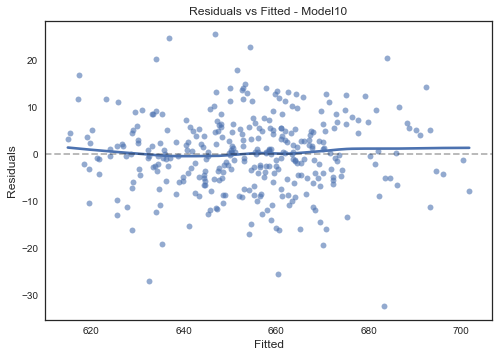

In [119]:
fig, ax= plt.subplots()
sns.regplot(fitted10, resid10, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model10') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

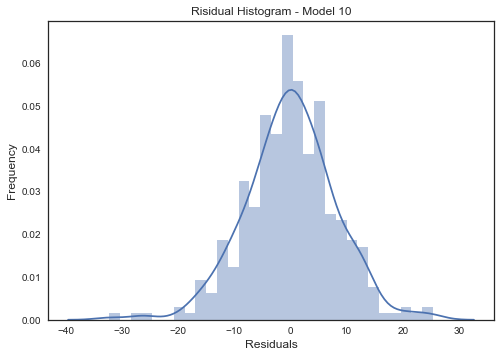

In [121]:
ax = sns.distplot(resid10, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risidual Histogram - Model 10')
plt.show()

In [122]:
from scipy import stats
stats.describe(resid10)

DescribeResult(nobs=336L, minmax=(-32.331911244603816, 25.382002621019524), mean=5.633588833526509e-13, variance=65.590362274389491, skewness=-0.15795292188078724, kurtosis=1.0649238886117347)

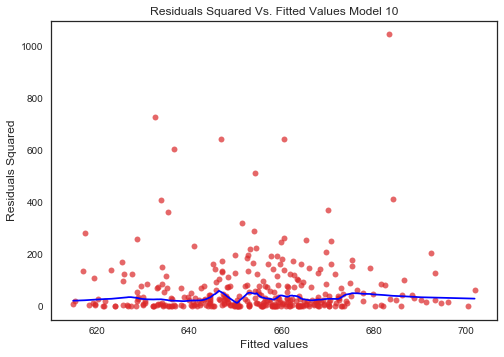

In [133]:
tableau=['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8c564b', '#e377c2', '#7f7f7f']
fig, ax= plt.subplots()
sns.regplot(fitted10,resid10**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Residuals Squared Vs. Fitted Values Model 10')
z1 = lowess(resid10**2, fitted10, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [125]:
features = train[['str','meal_pct','avginc','el_pct', 'Step1', 'Step2', 'Step3']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(7): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[1.1366748026919238, 52.142096724721242, 2.7063470727936925, 2.1339197213083625, 110.41162080671391, 49.637818087700431, 6.2381517793831369]


In [126]:
np.mean(vif)

32.058089856473245

In [124]:
summary.append({'formula': formula10, 'ser': ols10.mse_resid**0.5, 'rsquared': ols10.rsquared, 'rsqured_adj': ols10.rsquared_adj})

# Model 11 - M3 with log_avginc

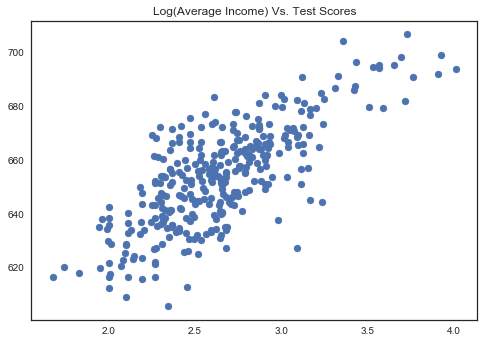

In [128]:
# justification: 
train['log_avginc'] = np.log(train['avginc'])
plt.scatter(train['log_avginc'], train['testscr'])
plt.title('Log(Average Income) Vs. Test Scores')
plt.show()

In [129]:
formula11= 'testscr ~ str + meal_pct + log_avginc + el_pct'
ols11 = smf.ols(formula=formula11, data=train).fit()
resid11 = ols11.resid
fitted11 = ols11.fittedvalues
ols11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     350.2
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          1.52e-117
Time:                        22:53:33   Log-Likelihood:                -1187.3
No. Observations:                 336   AIC:                             2385.
Df Residuals:                     331   BIC:                             2404.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    658.3621      8.440     78.009      0.000     641.760     674.964
str           -0.6869      0.247     -2.786      0.006      -1.172      -0.202
meal_pct      -0.4146      0.033    -12.480      0.000      -0.480      -0.349
log_avginc    11.3662      1.909      5.955      0.000       7.612      15.121
el_pct        -0.1557      0.036     -4.376      0.000      -0.226      -0.086
==============================================================================
Omnibus:                        9.633   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               16.589
Skew:                          -0.112   Prob(JB):                     0.000250
Kurtosis:                       4.065   Cond. No.                     1.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

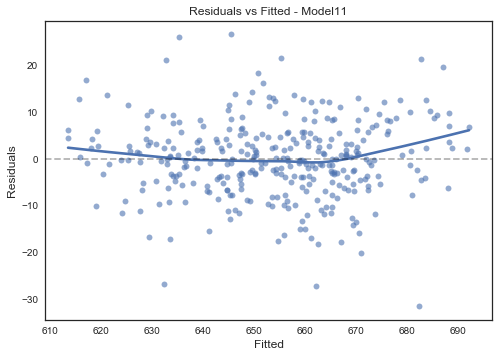

In [130]:
fig, ax= plt.subplots()
sns.regplot(fitted11, resid11, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model11') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

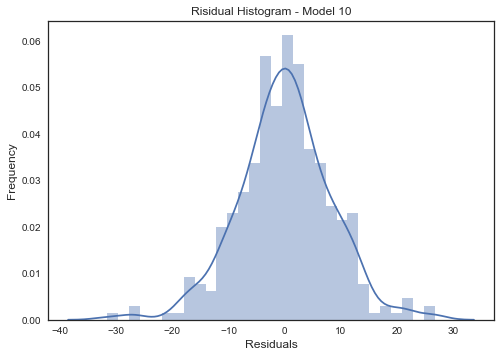

In [131]:
ax = sns.distplot(resid11, bins=30)
ax.set_xlabel('Residuals',  {'fontsize': 12})
ax.set_ylabel('Frequency', {'fontsize': 12})
ax.set_title('Risidual Histogram - Model 10')
plt.show()

In [132]:
stats.describe(resid11)

DescribeResult(nobs=336L, minmax=(-31.581204676882521, 26.689771793567729), mean=4.7775540137774357e-13, variance=68.888955005110049, skewness=-0.11166510045196595, kurtosis=1.0653815632903818)

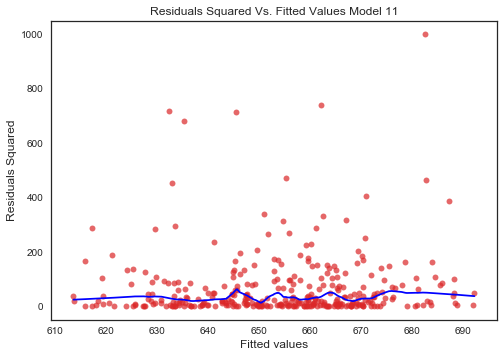

In [134]:
fig, ax= plt.subplots()
sns.regplot(fitted11,resid11**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Residuals Squared Vs. Fitted Values Model 11')
z1 = lowess(resid11**2, fitted11, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [135]:
features = train[['str','meal_pct','log_avginc','el_pct']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(4): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[1.0804607446460184, 3.9307286054685857, 2.6402472548921616, 1.9650305781493878]


In [136]:
np.mean(vif)

2.4041167957890384

In [137]:
summary.append({'formula': formula11, 'ser': ols11.mse_resid**0.5, 'rsquared': ols11.rsquared, 'rsqured_adj': ols11.rsquared_adj})

# Model 12 - Model 3 with sqrt_el_pct

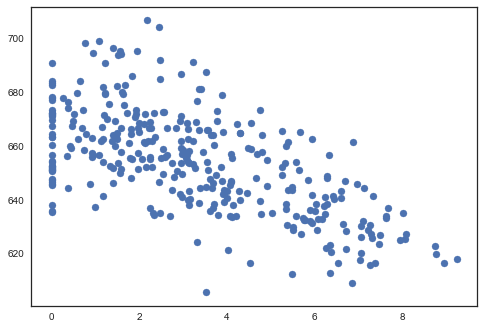

In [138]:
# justification
train['sqrt_el_pct'] = np.sqrt(train['el_pct'])
plt.scatter(train['sqrt_el_pct'], train['testscr'])
plt.show()

In [140]:
formula12= 'testscr ~ str + meal_pct + avginc + sqrt_el_pct'
ols12 = smf.ols(formula=formula12, data=train).fit()
resid12 = ols12.resid
fitted12 = ols12.fittedvalues
ols12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     373.6
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          2.54e-121
Time:                        23:17:41   Log-Likelihood:                -1178.5
No. Observations:                 336   AIC:                             2367.
Df Residuals:                     331   BIC:                             2386.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     675.3021      5.691    118.662      0.000     664.107     686.497
str            -0.4328      0.247     -1.752      0.081      -0.919       0.053
meal_pct       -0.4161      0.029    -14.384      0.000      -0.473      -0.359
avginc          0.6689      0.091      7.381      0.000       0.491       0.847
sqrt_el_pct    -1.3841      0.266     -5.198      0.000      -1.908      -0.860
==============================================================================
Omnibus:                       11.574   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               20.785
Skew:                          -0.158   Prob(JB):                     3.07e-05
Kurtosis:                       4.177   Cond. No.                         725.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

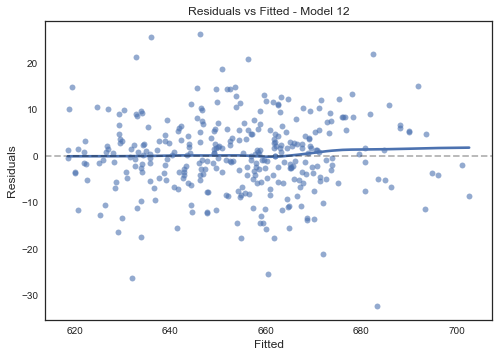

In [141]:
fig, ax= plt.subplots()
sns.regplot(fitted12, resid12, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model 12') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

In [142]:
stats.describe(resid12)

DescribeResult(nobs=336L, minmax=(-32.362333564100709, 26.08690643577097), mean=-6.9464011262642173e-13, variance=65.35631226479741, skewness=-0.1582806380396196, kurtosis=1.1766158677990424)

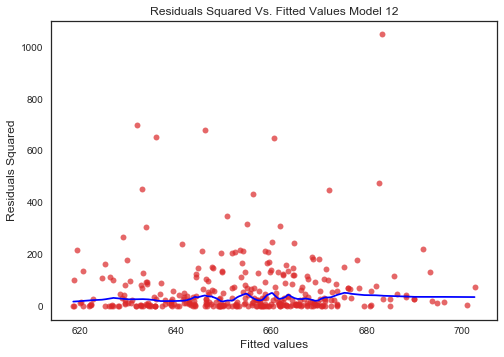

In [143]:
fig, ax= plt.subplots()
sns.regplot(fitted12,resid12**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Residuals Squared Vs. Fitted Values Model 12')
z1 = lowess(resid12**2, fitted12, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [144]:
features = train[['str','meal_pct','avginc','sqrt_el_pct']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(4): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[1.1427632176871143, 3.140912542447309, 2.1301791551409432, 1.9076400066148773]


In [145]:
np.mean(vif)

2.0803737304725614

In [146]:
summary.append({'formula': formula12, 'ser': ols12.mse_resid**0.5, 'rsquared': ols12.rsquared, 'rsqured_adj': ols12.rsquared_adj})

# Model 13 - Model 3 with log(expn_stu)

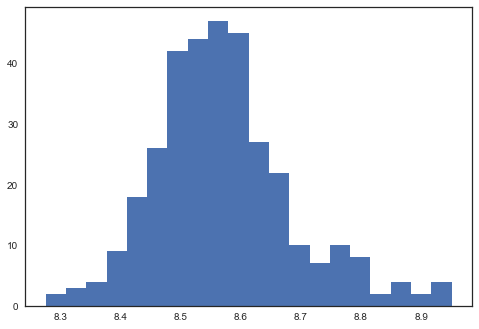

In [151]:
train['log_expn'] = np.log(train['expn_stu'])
plt.hist(train['log_expn'], bins=20)
plt.show()

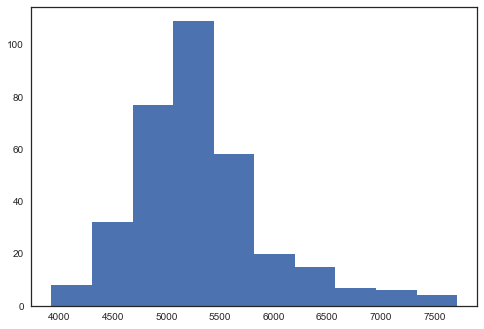

In [152]:
plt.hist(train['expn_stu'])
plt.show()

(array([  5.,  13.,  44.,  86.,  92.,  49.,  17.,  18.,   6.,   6.]),
 array([ 8.2753941 ,  8.34290158,  8.41040906,  8.47791653,  8.54542401,
         8.61293149,  8.68043897,  8.74794645,  8.81545393,  8.88296141,
         8.95046889]),
 <a list of 10 Patch objects>)

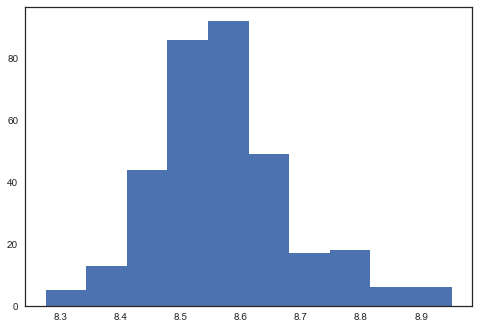

In [150]:
plt.hist(train['log_expn'])

In [153]:
formula13= 'testscr ~ str + meal_pct + avginc + el_pct + log_expn'
ols13 = smf.ols(formula=formula13, data=train).fit()
resid13 = ols13.resid
fitted13 = ols13.fittedvalues
ols13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     301.0
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          1.37e-120
Time:                        23:23:08   Log-Likelihood:                -1177.1
No. Observations:                 336   AIC:                             2366.
Df Residuals:                     330   BIC:                             2389.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    556.1786     49.570     11.220      0.000     458.665     653.692
str           -0.0637      0.311     -0.205      0.838      -0.675       0.548
meal_pct      -0.4331      0.030    -14.443      0.000      -0.492      -0.374
avginc         0.5755      0.095      6.076      0.000       0.389       0.762
el_pct        -0.1672      0.035     -4.816      0.000      -0.235      -0.099
log_expn      13.0924      5.384      2.432      0.016       2.501      23.683
==============================================================================
Omnibus:                       10.509   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               18.922
Skew:                          -0.117   Prob(JB):                     7.78e-05
Kurtosis:                       4.139   Cond. No.                     6.80e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

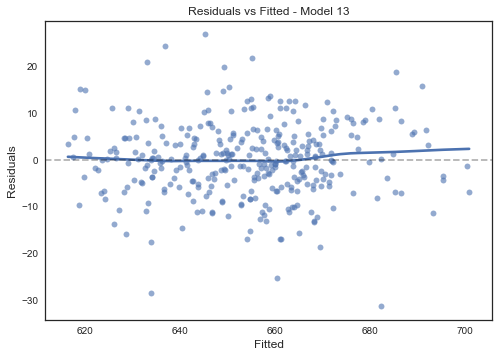

In [154]:
fig, ax= plt.subplots()
sns.regplot(fitted13, resid13, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model 13') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

In [155]:
stats.describe(resid13)

DescribeResult(nobs=336L, minmax=(-31.340467529813168, 26.892155204093228), mean=8.6517036920884578e-13, variance=64.827677596844225, skewness=-0.11727249593555372, kurtosis=1.1386638064451988)

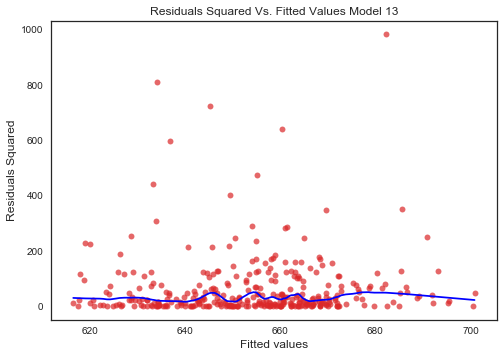

In [169]:
fig, ax= plt.subplots()
sns.regplot(fitted13,resid13**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Residuals Squared Vs. Fitted Values Model 13')
z1 = lowess(resid13**2, fitted13, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [157]:
features = train[['str','meal_pct','avginc','el_pct', 'log_expn']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(5): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[1.8207919159104247, 3.3916735274280665, 2.3384701202710119, 1.9823485740374298, 1.9740224563905033]


In [158]:
np.mean(vif)

2.3014613188074873

In [159]:
summary.append({'formula': formula13, 'ser': ols13.mse_resid**0.5, 'rsquared': ols13.rsquared, 'rsqured_adj': ols13.rsquared_adj})

# Model 14 - Model 3 with sqrt(comp_stu)

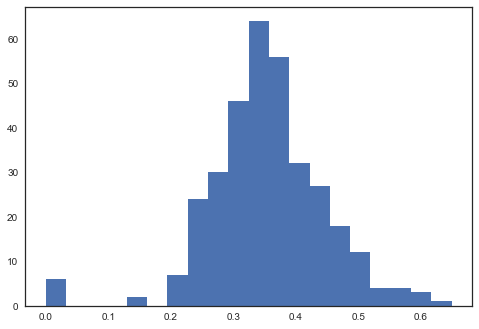

In [162]:
# justification
train['sqrt_comp'] = np.sqrt(train['comp_stu'])
plt.hist(train['sqrt_comp'], bins=20)
plt.show()

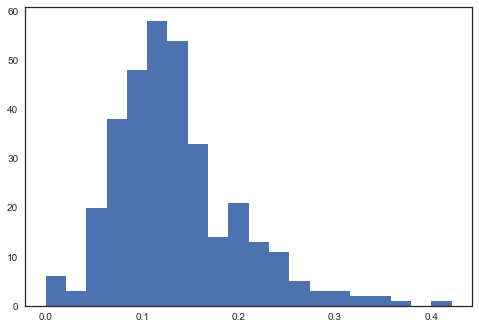

In [164]:
plt.hist(train['comp_stu'], bins=20)
plt.show()

In [165]:
formula14= 'testscr ~ str + meal_pct + avginc + el_pct + sqrt_comp'
ols14 = smf.ols(formula=formula14, data=train).fit()
resid14 = ols14.resid
fitted14 = ols14.fittedvalues
ols14.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     308.2
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          5.53e-122
Time:                        23:27:58   Log-Likelihood:                -1173.8
No. Observations:                 336   AIC:                             2360.
Df Residuals:                     330   BIC:                             2383.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    665.2874      6.369    104.449      0.000     652.758     677.817
str           -0.3184      0.248     -1.284      0.200      -0.806       0.170
meal_pct      -0.4147      0.029    -14.254      0.000      -0.472      -0.357
avginc         0.6279      0.089      7.051      0.000       0.453       0.803
el_pct        -0.1590      0.035     -4.608      0.000      -0.227      -0.091
sqrt_comp     17.9397      5.068      3.539      0.000       7.969      27.910
==============================================================================
Omnibus:                        9.988   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               17.859
Skew:                          -0.099   Prob(JB):                     0.000132
Kurtosis:                       4.112   Cond. No.                         967.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

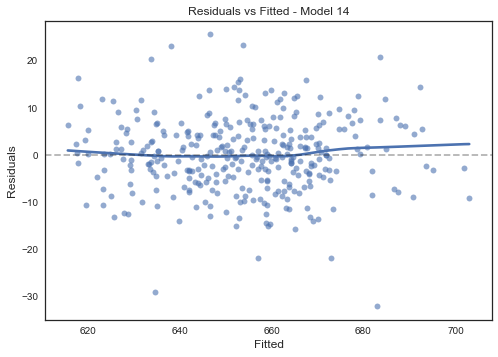

In [166]:
fig, ax= plt.subplots()
sns.regplot(fitted14, resid14, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model 14') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

In [167]:
stats.describe(resid14)

DescribeResult(nobs=336L, minmax=(-32.076572379959543, 25.521656720749775), mean=1.3899569326202341e-12, variance=63.575830958781204, skewness=-0.09891763973069971, kurtosis=1.1119933103676019)

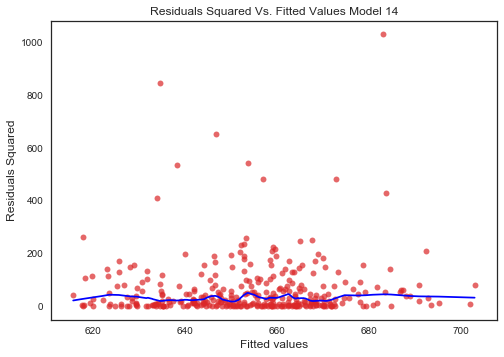

In [168]:
fig, ax= plt.subplots()
sns.regplot(fitted14,resid14**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Residuals Squared Vs. Fitted Values Model 14')
z1 = lowess(resid14**2, fitted14, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [170]:
features = train[['str','meal_pct','avginc','el_pct', 'sqrt_comp']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(5): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[1.1814519786416768, 3.2557977940810017, 2.1085896283528411, 1.9960774072232956, 1.1582929766215166]


In [171]:
np.mean(vif)

1.9400419569840666

In [172]:
summary.append({'formula': formula14, 'ser': ols14.mse_resid**0.5, 'rsquared': ols14.rsquared, 'rsqured_adj': ols14.rsquared_adj})

# Model 15 - FS with all variables created up to this point

In [181]:
model = forward_selected(train[['testscr','str','enrl_tot','teachers','computer','expn_stu','el_pct','meal_pct', 'Step1','Step2','Step3','comp_meal','avginc_meal', 'calw_pct','avginc','comp_stu' , 'el_str','calw_str','expn_comp','avginc_comp','log_avginc','sqrt_el_pct','log_expn','sqrt_comp']], 'testscr', nominated=['str'] )

you nominated variable(s) ['str'], the adj_r2 is: 0.049352
adding meal_pct increases adj_r2 from 0.049352 to 0.782474
adding avginc_comp increases adj_r2 from 0.782474 to 0.803363
adding sqrt_el_pct increases adj_r2 from 0.803363 to 0.811113
adding avginc increases adj_r2 from 0.811113 to 0.818273
adding sqrt_comp increases adj_r2 from 0.818273 to 0.822556
adding expn_stu increases adj_r2 from 0.822556 to 0.824272
adding comp_stu increases adj_r2 from 0.824272 to 0.825482
final model is testscr ~ str + meal_pct + avginc_comp + sqrt_el_pct + avginc + sqrt_comp + expn_stu + comp_stu + 1, with adj_r2 of 0.825482


In [182]:
formula15= 'testscr ~ str + meal_pct + avginc_comp + sqrt_el_pct'
ols15 = smf.ols(formula=formula15, data=train).fit()
resid15 = ols15.resid
fitted15 = ols15.fittedvalues
ols15.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     360.6
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          3.02e-119
Time:                        23:51:11   Log-Likelihood:                -1183.3
No. Observations:                 336   AIC:                             2377.
Df Residuals:                     331   BIC:                             2396.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     681.3680      5.458    124.842      0.000     670.632     692.104
str            -0.3626      0.256     -1.416      0.158      -0.867       0.141
meal_pct       -0.4825      0.025    -19.640      0.000      -0.531      -0.434
avginc_comp     2.0755      0.315      6.595      0.000       1.456       2.695
sqrt_el_pct    -0.9896      0.259     -3.824      0.000      -1.499      -0.481
==============================================================================
Omnibus:                       13.930   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.272
Skew:                          -0.239   Prob(JB):                     5.36e-06
Kurtosis:                       4.227   Cond. No.                         672.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

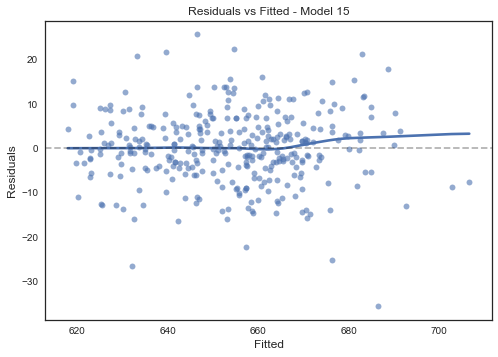

In [183]:
fig, ax= plt.subplots()
sns.regplot(fitted15, resid15, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model 15') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

In [184]:
stats.describe(resid15)

DescribeResult(nobs=336L, minmax=(-35.692303944886589, 25.664547896373392), mean=-5.596369928320027e-13, variance=67.27432337621282, skewness=-0.23899083345846472, kurtosis=1.2268926119530335)

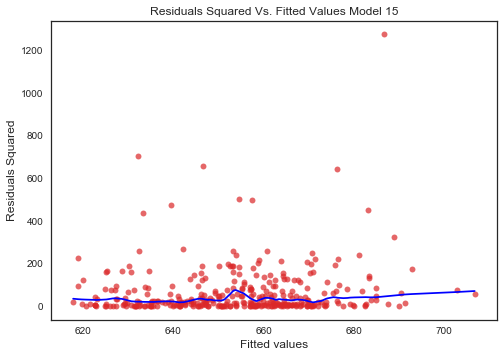

In [185]:
fig, ax= plt.subplots()
sns.regplot(fitted15,resid15**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Residuals Squared Vs. Fitted Values Model 15')
z1 = lowess(resid15**2, fitted15, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [186]:
features = train[['str','meal_pct', 'avginc_comp','sqrt_el_pct']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(4): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[1.1943095628458242, 2.2012441939034932, 1.5947529195234866, 1.7503580743243679]


In [187]:
np.mean(vif)

1.6851661876492932

In [188]:
summary.append({'formula': formula15, 'ser': ols15.mse_resid**0.5, 'rsquared': ols15.rsquared, 'rsqured_adj': ols15.rsquared_adj})

# Model 16 - FS without any reference to meal_pct

In [189]:
model = forward_selected(train[['testscr','str','enrl_tot','teachers','computer','expn_stu','el_pct', 'calw_pct','avginc','comp_stu' , 'el_str','calw_str','expn_comp','avginc_comp','log_avginc','sqrt_el_pct','log_expn','sqrt_comp']], 'testscr', nominated=['str'] )

you nominated variable(s) ['str'], the adj_r2 is: 0.049352
adding log_avginc increases adj_r2 from 0.049352 to 0.572847
adding sqrt_el_pct increases adj_r2 from 0.572847 to 0.721138
adding calw_pct increases adj_r2 from 0.721138 to 0.760443
adding sqrt_comp increases adj_r2 from 0.760443 to 0.765284
adding avginc increases adj_r2 from 0.765284 to 0.767271
adding el_pct increases adj_r2 from 0.767271 to 0.768074
adding calw_str increases adj_r2 from 0.768074 to 0.768816
adding comp_stu increases adj_r2 from 0.768816 to 0.770160
adding log_expn increases adj_r2 from 0.770160 to 0.770337
final model is testscr ~ str + log_avginc + sqrt_el_pct + calw_pct + sqrt_comp + avginc + el_pct + calw_str + comp_stu + log_expn + 1, with adj_r2 of 0.770337


In [190]:
formula16 = 'testscr ~ str + log_avginc + sqrt_el_pct + calw_pct'
ols16 = smf.ols(formula=formula16, data=train).fit()
resid16 = ols16.resid
fitted16 = ols16.fittedvalues
ols16.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     266.9
Date:                Wed, 01 Nov 2017   Prob (F-statistic):          3.42e-102
Time:                        23:55:54   Log-Likelihood:                -1223.3
No. Observations:                 336   AIC:                             2457.
Df Residuals:                     331   BIC:                             2476.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     614.2886      8.007     76.715      0.000     598.537     630.040
str            -0.3510      0.277     -1.265      0.207      -0.897       0.195
log_avginc     23.4327      1.659     14.123      0.000      20.169      26.696
sqrt_el_pct    -3.1011      0.241    -12.847      0.000      -3.576      -2.626
calw_pct       -0.4041      0.054     -7.448      0.000      -0.511      -0.297
==============================================================================
Omnibus:                       10.692   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               15.930
Skew:                          -0.222   Prob(JB):                     0.000347
Kurtosis:                       3.970   Cond. No.                         402.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

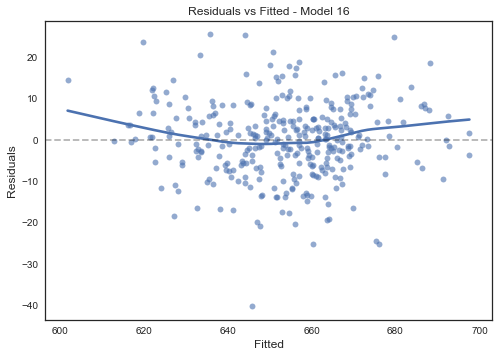

In [191]:
fig, ax= plt.subplots()
sns.regplot(fitted16, resid16, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}) # remember to use untransformed fitted values if you transformed Y
ax.set_xlabel('Fitted',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Residuals vs Fitted - Model 16') # title = current model
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

In [192]:
stats.describe(resid16)

DescribeResult(nobs=336L, minmax=(-40.230436587089002, 25.453841167380688), mean=-8.4588420923821453e-14, variance=85.320892466668781, skewness=-0.22244930409944014, kurtosis=0.9695120490784381)

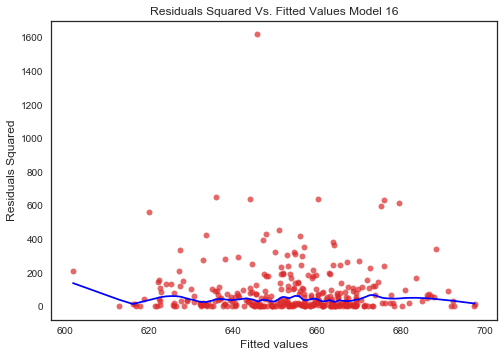

In [193]:
fig, ax= plt.subplots()
sns.regplot(fitted16,resid16**2, ci=None, fit_reg=False, scatter_kws={'s': 35, 'color': tableau[3], 'alpha': 0.7})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals Squared', {'fontsize': 12})
ax.set_title('Residuals Squared Vs. Fitted Values Model 16')
z1 = lowess(resid16**2, fitted16, frac=1./10)
plt.plot(z1[:,0],z1[:,1],'blue')
plt.show()

In [194]:
features = train[['str','log_avginc','sqrt_el_pct','calw_pct']] # add in all varibles for current model
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(4): # range is number of selected variables + 1
    vif.append(variance_inflation_factor(features.values, i+1))
    
print(vif)

[1.1043533120724314, 1.6109999643104733, 1.2006190712602358, 1.5449784949398346]


In [195]:
np.mean(vif)

1.3652377106457436

In [196]:
summary.append({'formula': formula16, 'ser': ols16.mse_resid**0.5, 'rsquared': ols16.rsquared, 'rsqured_adj': ols16.rsquared_adj})

In [199]:
summary

[{'formula': 'testscr ~ str + enrl_tot + expn_stu + el_pct + meal_pct + calw_pct + avginc + comp_stu',
  'rsquared': 0.82410073351658897,
  'rsqured_adj': 0.81979738754757592,
  'ser': 8.0595836938627468},
 {'formula': 'testscr ~ str + meal_pct + avginc + el_pct + comp_stu + expn_stu',
  'rsquared': 0.82374142375049941,
  'rsqured_adj': 0.82052698163044768,
  'ser': 8.0432515540219409},
 {'formula': 'testscr ~ str + meal_pct + avginc + el_pct',
  'rsquared': 0.81693302475456742,
  'rsqured_adj': 0.81472073502350484,
  'ser': 8.172322144068298},
 {'formula': 'testscr ~ str + meal_pct + avginc + el_pct + el_str',
  'rsquared': 0.81714438571987813,
  'rsqured_adj': 0.81437384610957331,
  'ser': 8.1799688774733941},
 {'formula': 'testscr ~ str + meal_pct + avginc + el_pct + calw_pct + calw_str',
  'rsquared': 0.8172407684346733,
  'rsqured_adj': 0.81390777333013853,
  'ser': 8.1902316304717857},
 {'formula': 'testscr ~ str + meal_pct + avginc + el_pct + comp_stu + comp_meal',
  'rsquared':